In [1]:
! pip install datasets transformers

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [3]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [4]:
VIDEO_PATH = "/kaggle/input/unber-1111/UNBER-1k/Extracted_Frames"

In [5]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [6]:
X_video, y = [], []

In [7]:
TEXT_CSV = "/kaggle/input/unber-1111/UNBER-1k/text.csv"

In [8]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [9]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [11]:
tdf.head()

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1000188341415358,Safe,Me on my way to watch Oppenheimer After Berbie
1,www.facebook.com/reel/1006146964533997,Safe,কোন টেক্সট পাওয়া যায়নি
2,www.facebook.com/reel/1007123741459823,Adult,বান্ধবী আমার লাগানির পিনিকে আছে Love in love
3,www.facebook.com/reel/1007420607202244,Safe,প্রত্যেকটা অফিসে এমন একজন কলিগ থাকবেই Laptop
4,www.facebook.com/reel/1008519870870927,Safe,হ্যালো শার্ক ট্যাঙ্ক বাংলাদেশ আই এম কামিং


In [10]:
tdf['UnsafeType'].value_counts()

UnsafeType
Safe        441
Adult       327
Harmful     221
Suicidal    122
Name: count, dtype: int64

In [11]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [12]:
for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)

    if os.path.isdir(video_folder):
        frames = load_video_frames(video_folder)    

        X_video.append(frames)
        y.append(label)

In [13]:
print(len(X_video), len(y))

1111 1111


In [14]:
X_video = np.array(X_video)  
y = np.array(y)

In [15]:
print(X_video.shape)
print(y.shape)

(1111, 5, 224, 224, 3)
(1111,)


In [16]:
X_train_vid, X_temp, y_train, y_temp = train_test_split(X_video, y, test_size=0.2, random_state=42, stratify=y)
X_val_vid, X_test_vid, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [17]:
print(X_train_vid.shape)
print(X_val_vid.shape)
print(X_test_vid.shape)

(888, 5, 224, 224, 3)
(111, 5, 224, 224, 3)
(112, 5, 224, 224, 3)


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import ViTModel, ViTFeatureExtractor

In [22]:
model_name_or_path = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [23]:
vit_model = ViTModel.from_pretrained(model_name_or_path)
vit_model.eval()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [24]:
class ViT_LSTM_Model(nn.Module):
    def __init__(self, vit_model, lstm_hidden_size=256, num_classes=4):
        super(ViT_LSTM_Model, self).__init__()
        self.vit = vit_model
        self.lstm_hidden_size = lstm_hidden_size
        self.num_classes = num_classes

        # Freeze ViT parameters (only train LSTM and classifier)
        for param in self.vit.parameters():
            param.requires_grad = False

        # LSTM to process ViT feature sequences
        self.lstm = nn.LSTM(input_size=768, hidden_size=lstm_hidden_size, num_layers=1, batch_first=True)

        # Fully connected classifier
        self.fc = nn.Linear(lstm_hidden_size, num_classes)

    def forward(self, x):
        batch_size, num_frames, c, h, w = x.shape
        x = x.view(batch_size * num_frames, c, h, w)  # Flatten frames for ViT processing

        with torch.no_grad():  # Extract features using ViT (no gradient updates)
            features = self.vit(x).last_hidden_state[:, 0, :]  # CLS token embedding

        features = features.view(batch_size, num_frames, -1)  # Reshape back to (batch, num_frames, 768)

        lstm_out, _ = self.lstm(features)  # LSTM processing
        final_output = lstm_out[:, -1, :]  # Take the last LSTM output

        return self.fc(final_output)  # Classification output

In [25]:
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [26]:
class VideoDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx]  # Shape: (num_frames, 224, 224, 3)
        label = self.y[idx]

        # Convert to tensor and normalize
        video = torch.tensor(video, dtype=torch.float32).permute(0, 3, 1, 2) / 255.0  # (num_frames, 3, 224, 224)
        return video, torch.tensor(label, dtype=torch.long)

In [28]:
train_dataset = VideoDataset(X_train_vid, y_train)
val_dataset = VideoDataset(X_val_vid, y_val)
test_dataset = VideoDataset(X_test_vid, y_test)

In [29]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_LSTM_Model(vit_model).to(device)

In [31]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [32]:
num_epochs = 10

In [33]:
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for videos, labels in train_loader:
        videos, labels = videos.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [1/10], Loss: 1.1804
Epoch [2/10], Loss: 0.9068
Epoch [3/10], Loss: 0.7487
Epoch [4/10], Loss: 0.6109
Epoch [5/10], Loss: 0.4826
Epoch [6/10], Loss: 0.3589
Epoch [7/10], Loss: 0.2510
Epoch [8/10], Loss: 0.1591
Epoch [9/10], Loss: 0.1030
Epoch [10/10], Loss: 0.0673


In [34]:
torch.save(model.state_dict(), "vit_lstm_model.pth")

In [35]:
from sklearn.metrics import classification_report

In [36]:
model.eval()
all_preds, all_labels = [], []

In [37]:
with torch.no_grad():
    for videos, labels in test_loader:
        videos, labels = videos.to(device), labels.to(device)
        outputs = model(videos)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

In [38]:
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.5636    0.6889    0.6200        45
           1     0.5161    0.4848    0.5000        33
           2     0.4667    0.3182    0.3784        22
           3     0.8182    0.7500    0.7826        12

    accuracy                         0.5625       112
   macro avg     0.5912    0.5605    0.5702       112
weighted avg     0.5579    0.5625    0.5546       112



In [39]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

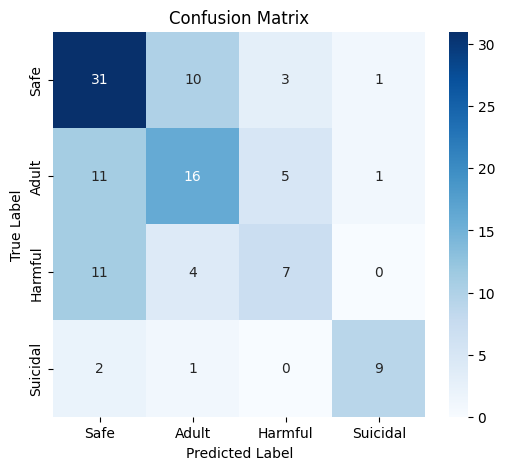

In [41]:
class_names = ['Safe', 'Adult', 'Harmful', 'Suicidal']  
plot_confusion_matrix(all_labels, all_preds, class_names)